# **ARIMA Analysis**

Text(0.5, 1.0, 'Sales for All Items')

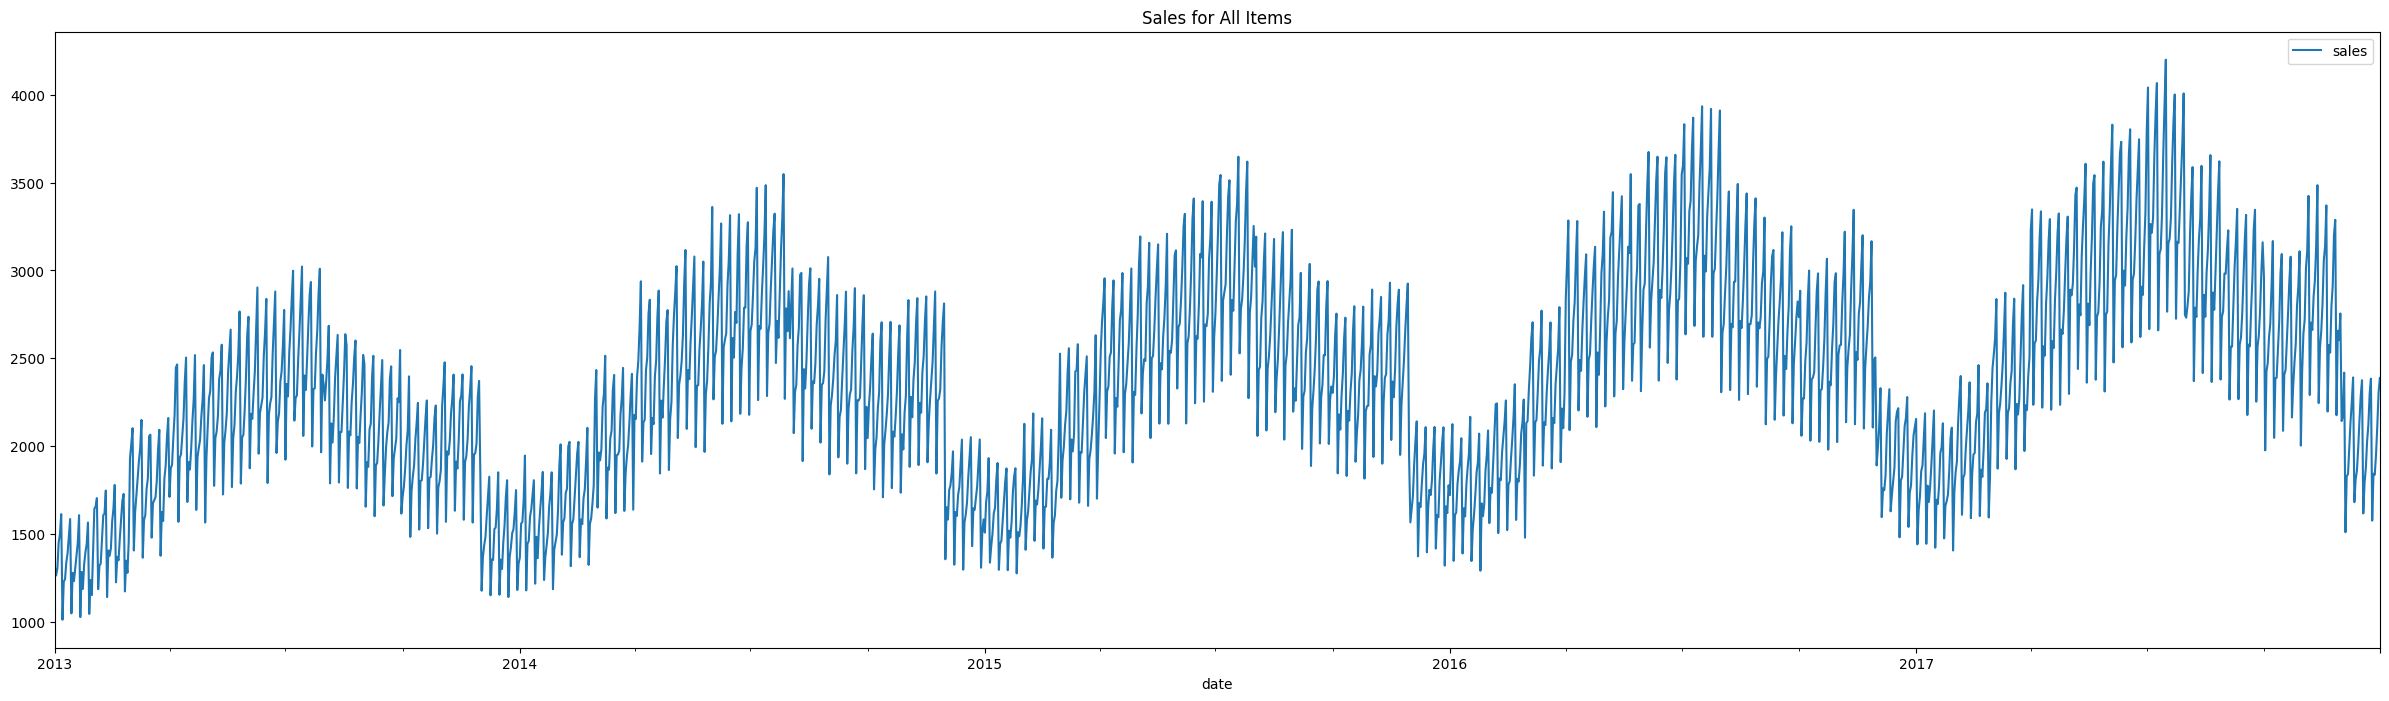

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

df = pd.read_csv('https://raw.githubusercontent.com/BekBrace/Sales-Forecast-data-csv/main/train.csv')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Use only data from store
trim = df[df['store'] == 1]
# trim = trim.drop('store', axis =1)
# trim = trim.drop('item', axis = 1)

sum = trim.groupby(['date'])['sales'].sum().reset_index()
sum.set_index('date',inplace=True)

fig = sum[['sales']].plot(figsize=(30,8))
fig.set_title("Sales for All Items")


## Check p value

In [4]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("valid p-value")
    else:
        print("invalid p-value")


adfuller_test(sum['sales'])

ADF Test Statistic : -2.9840769991201777
p-value : 0.03640840305195685
#Lags Used : 22
Number of Observations Used : 1803
valid p-value


In [5]:
sum['Sale First Difference'] = sum['sales'] - sum['sales'].shift(1)
sum['Seasonal First Difference'] = sum['sales'] - sum['sales'].shift(12)

adfuller_test(sum['Seasonal First Difference'].dropna())

ADF Test Statistic : -4.756995611102768
p-value : 6.568057771917737e-05
#Lags Used : 25
Number of Observations Used : 1788
valid p-value


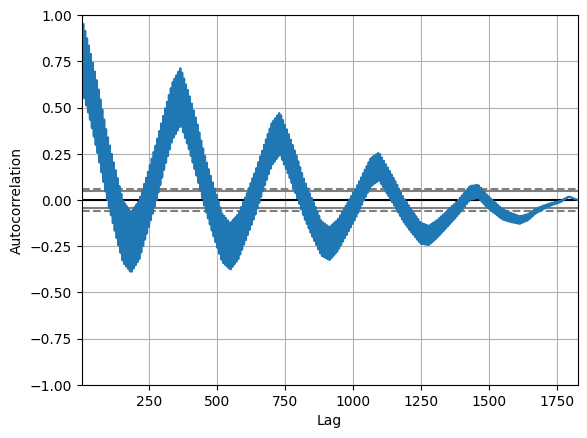

In [6]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(sum['sales'])
plt.show()

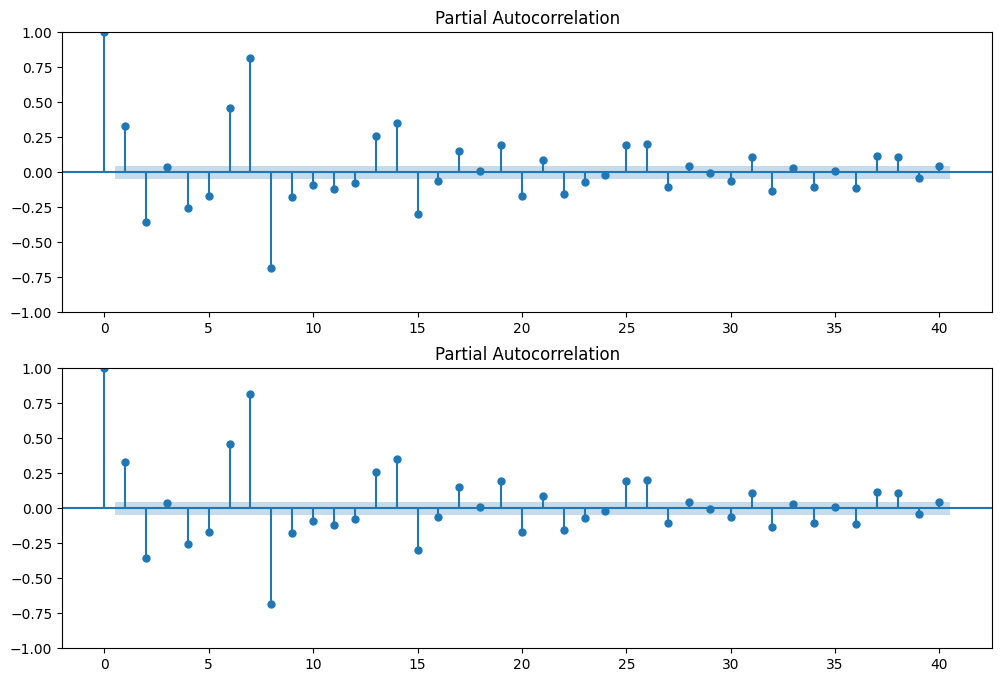

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(sum['Seasonal First Difference'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sum['Seasonal First Difference'].iloc[13:], lags=40, ax=ax2)


## **Train with ARIMA**

In [8]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(sum['sales'], order=(3,1,2))
model_fit = model.fit()
model_fit.summary()


from sklearn.metrics import mean_squared_error, r2_score

sum['forecast'] = model_fit.predict()

sales = sum['sales']
forecast = sum['forecast']

mse = mean_squared_error(sales, forecast)
r2 = r2_score(sales, forecast)
print(mse)
print (r2)



/Users/wxuerui/sales-pridiction-colab-files/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/wxuerui/sales-pridiction-colab-files/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/wxuerui/sales-pridiction-colab-files/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/wxuerui/sales-pridiction-colab-files/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parame

79067.93534184106
0.7673837536858572


r2_Score:  0.7673837536858572


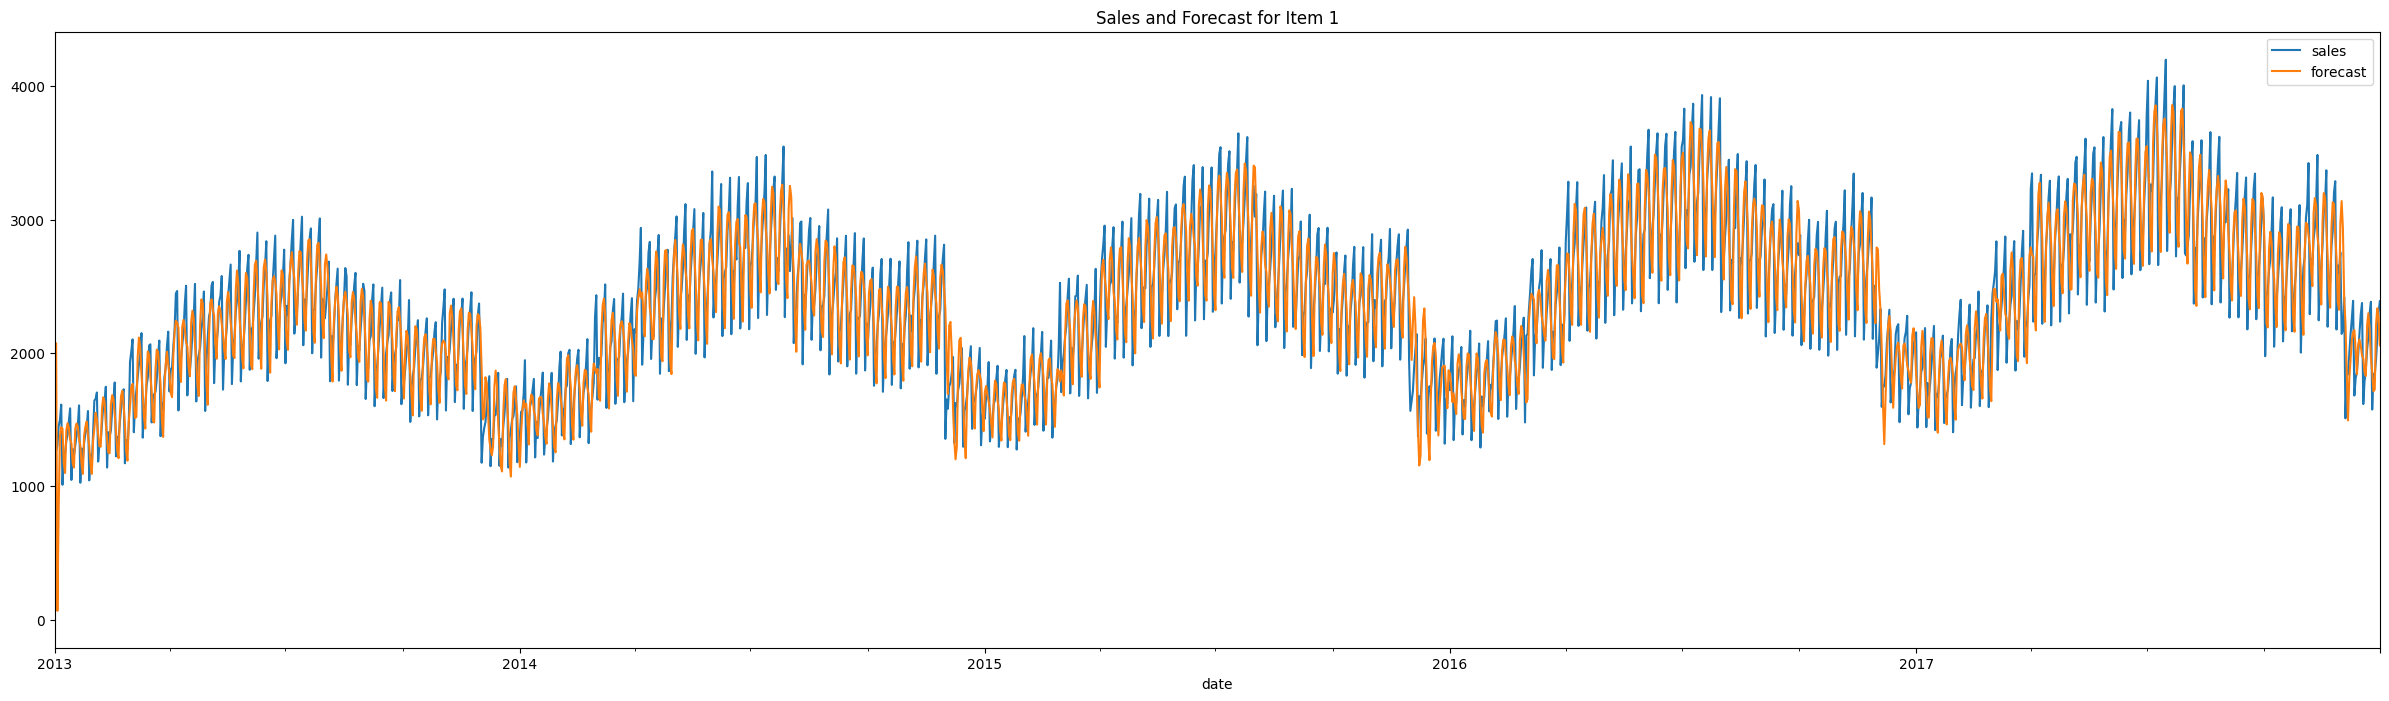

In [9]:
# sum['forecast'] = model_fit.predict(start=200, end=300, dynamic=True)
sum['forecast'] = model_fit.predict()

fig = sum[['sales', 'forecast']].plot(figsize=(30,8))
fig.set_title("Sales and Forecast for Item 1")
print('r2_Score: ', r2)

/Users/wxuerui/sales-pridiction-colab-files/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/wxuerui/sales-pridiction-colab-files/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.59187D+00    |proj g|=  1.26326D-01

At iterate    5    f=  7.42112D+00    |proj g|=  6.47215D-02

At iterate   10    f=  7.40613D+00    |proj g|=  1.00965D-02

At iterate   15    f=  7.40283D+00    |proj g|=  1.72650D-03

At iterate   20    f=  7.20185D+00    |proj g|=  1.52719D-02

At iterate   25    f=  7.20152D+00    |proj g|=  4.49348D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     33      1     0     0   

<Axes: xlabel='date'>

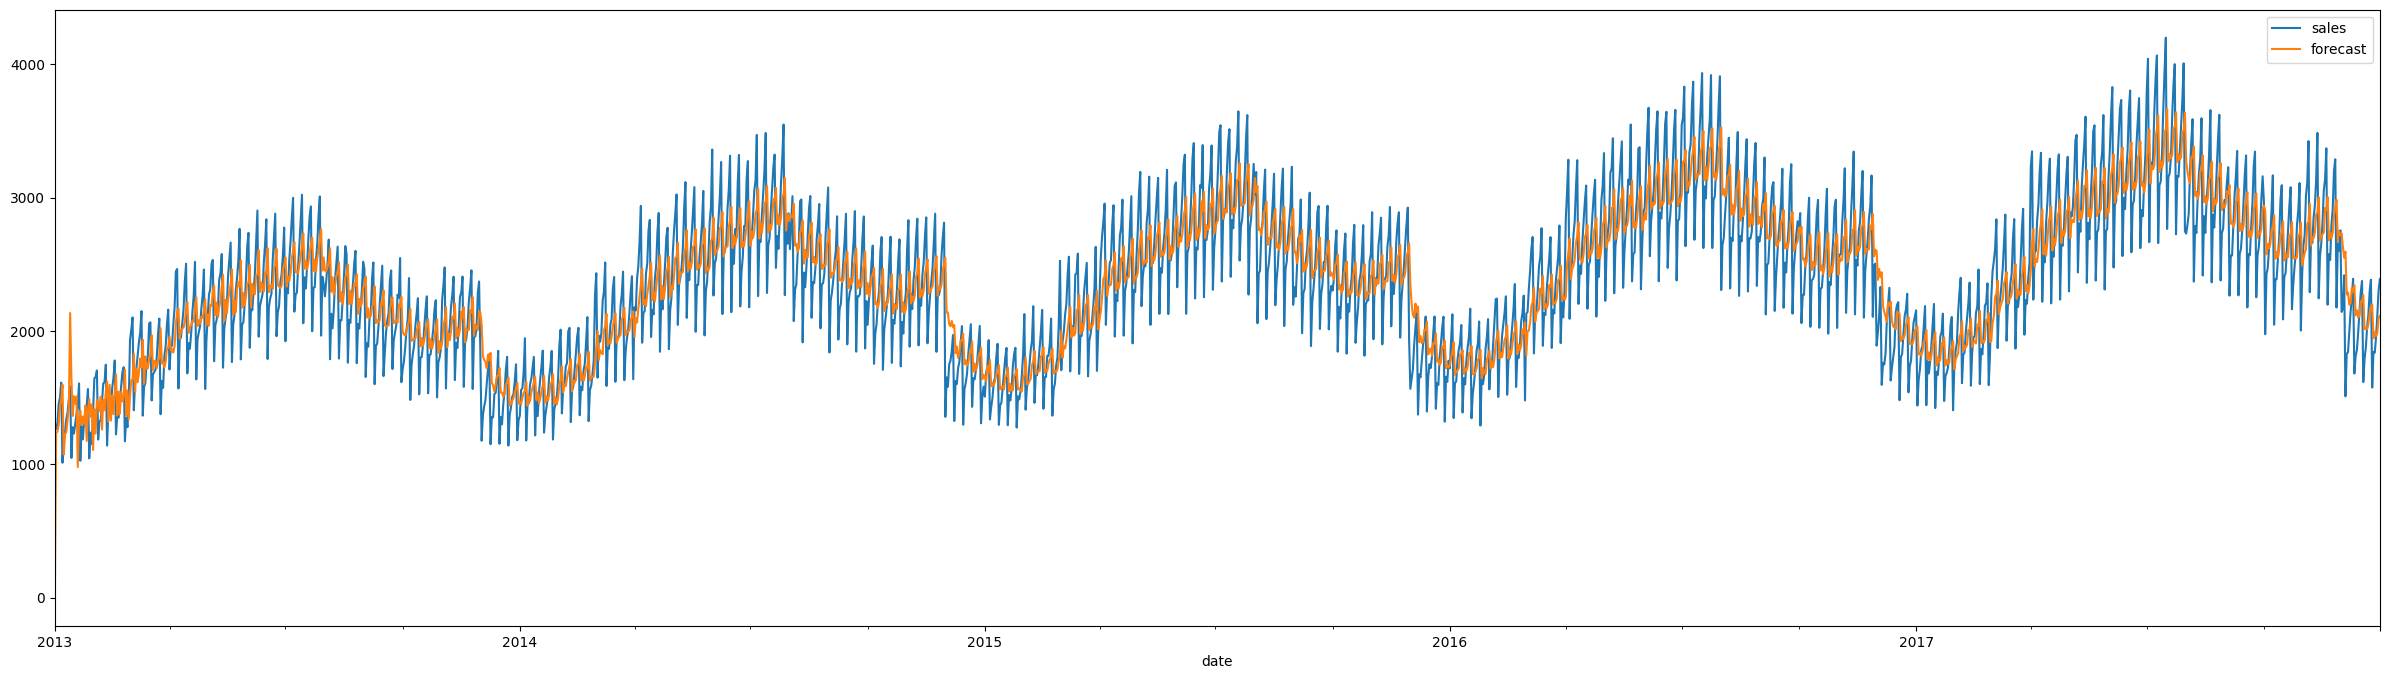

In [10]:
# Seasonal ARIMA

import statsmodels.api as sm

model=sm.tsa.statespace.SARIMAX(sum['sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

sum['forecast'] = results.predict()

sales = sum['sales']
forecast = sum['forecast']

mse = mean_squared_error(sales, forecast)
r2 = r2_score(sales, forecast)
print(mse)
print (r2)

# sum['forecast'] = results.predict(start =500, end= 1500 )
sum[['sales', 'forecast']].plot(figsize=(30,8))

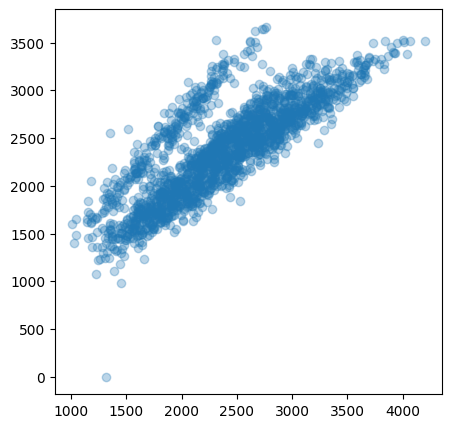

In [11]:
# Forecast plot

import numpy as np

plt.figure(figsize=(5,5))
plt.scatter(x=sum['sales'], y=sum['forecast'], alpha=0.3)

z = np.polyfit(sum['sales'], sum['forecast'], 1)
p = np.poly1d(z)

In [12]:
from pandas.tseries.offsets import DateOffset

future_dates=[sum.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=sum.columns)
future_datest_df.tail()


,sales,Sale First Difference,Seasonal First Difference,forecast
2019-07-31,NaN,NaN,NaN,NaN
2019-08-31,NaN,NaN,NaN,NaN
2019-09-30,NaN,NaN,NaN,NaN
2019-10-31,NaN,NaN,NaN,NaN
2019-11-30,NaN,NaN,NaN,NaN


/var/folders/zz/zyxvpxvq6csfxvn_n000ccnw00335g/T/ipykernel_45331/1830665398.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  future_df=pd.concat([sum,future_datest_df])


<Axes: >

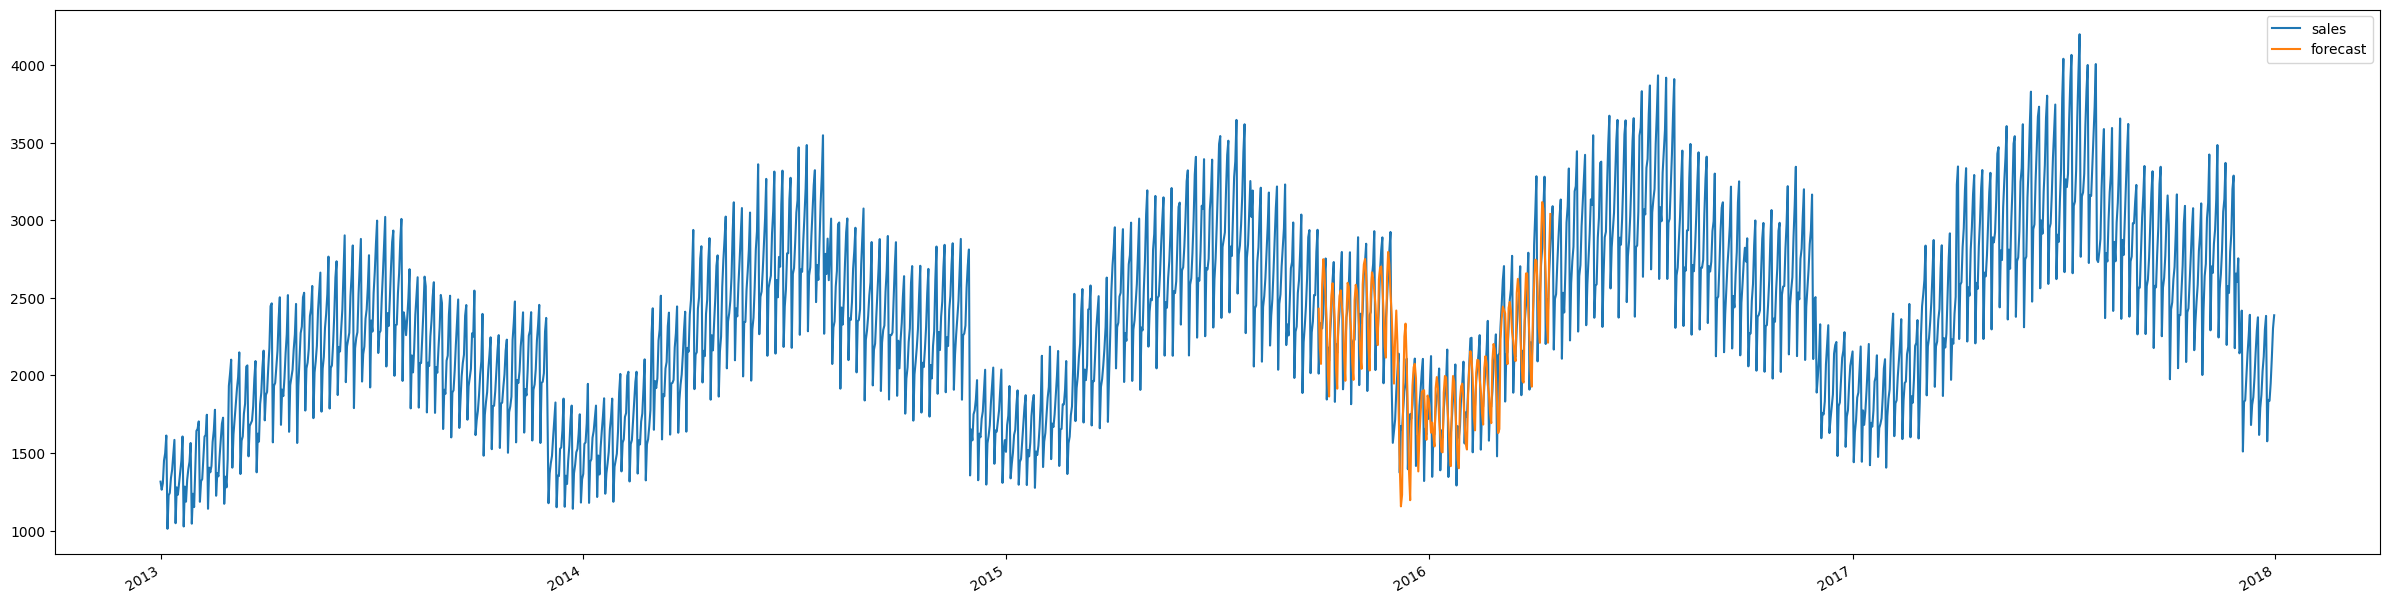

In [13]:
future_df=pd.concat([sum,future_datest_df])
future_df['forecast'] = model_fit.predict(start = 1000, end = 1200)
future_df[['sales', 'forecast']].plot(figsize=(30, 8))